# Choosing the profile and dimensions

In [1]:
from pathlib import Path
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from scipy.interpolate import interp1d
from pandas import Series, DataFrame
import pandas as pd

import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

import nemplot
from nemplot import nemplot_parameters

from IPython.display import display, HTML

In [2]:
DICT_LINES = 19

In [3]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [5]:
def filter_table_from_column(table,column,value):
    """
    Return a view into the 'table' DataFrame, selecting only the rows where
    'column' equals 'value'
    """
    
    return table[table[column] == value]

In [6]:
B_LABEL = r'$B\ped{h}\,[\si{\tesla}]$'
Q_LABEL = r'$\qc\,[\si{\watt}]$'
PHI_LABEL = r'$\Phi$'
H_REG_LABEL = r'$H\,[\si{\milli\meter}]$'
F_B_LABEL = r'$F\ped{B}\,[\si{\percent}]$'
F_M_LABEL = r'$F\ped{M}\,[\si{\percent}]$'
H_MAX_LABEL = r'$\overline{B}\ped{max}\,[\si{\tesla}]$'
COP_LABEL = r'$\cop$'

if sys.platform == 'darwin':
    PAPER_FOLDER = Path("/Volumes") / \
                        "GoogleDrive" / \
                        "My Drive"/ \
                        "PoloMag"/ \
                        "___PoloMag-Publico"/ \
                        "Conferences"/ \
                        "Themag_VIII_2018"/ \
                        "Papers_Thermag_VIII_2018"/ \
                        "Fortkamp et al - Integrated design AMR Magnet"
elif sys.platform == 'win32':
    PAPER_FOLDER = Path("G:") / \
                        "Meu Drive"/ \
                        "PoloMag"/ \
                        "___PoloMag-Publico"/ \
                        "Conferences"/ \
                        "Themag_VIII_2018"/ \
                        "Papers_Thermag_VIII_2018"/ \
                        "Fortkamp et al - Integrated design AMR Magnet"                      
                        
nemplot.set_main_path(PAPER_FOLDER)
nemplot.set_figures_dir('.')
nemplot.set_figsize_cm(10)
nemplot.set_fontsize(12)
nemplot.set_plot_extension('.jpg')
nemplot.set_dpi(1000)
nemplot.set_latex_font('Times')


In [7]:
PAPER_FOLDER.exists()

True

## Parameters

In [8]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "N_r[]": 8,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05,
    "F_M[%]": 35}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "R_o": 0.040,
                "h_fc": 0.005,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

### The estimated operating point

To define the target operating point, consider the refrigerated cabinet to be operated by the AMR system. The *cold source* is the refrigerated space inside the cabinet, and the *hot source* is the environment. In steady state, the cooling capacity must be high enough to maintain the interior at the cold temperature $T_{\mathrm{C}}$, despite heat leakage to the environment.

The experimental value of the thermal conductance of the cabinet between the interior and the environment is:

In [9]:
UA_CABINET_EXPERIMENTAL = 1.8 # W/K

and the temperature span is:

In [10]:
TARGET_TEMPERATURE_SPAN_CABINET = 20 # K 

and hence the target cooling capacity is:

In [11]:
TARGET_COOLING_CAPACITY = UA_CABINET_EXPERIMENTAL * TARGET_TEMPERATURE_SPAN_CABINET

For the heat exchangers that have been tested, a system temperature span of 20 K generate a regenerator temperature span of 35 K, so the maps of section 1 can be used.

To account for numerical errors and for the uncertainty in selecting the heat exchanger, we use a safety factor when specifying the actual target cooling capacity:

In [12]:
SAFETY_FACTOR = 3
Q_C_CRITICAL = TARGET_COOLING_CAPACITY * SAFETY_FACTOR

### Combining maps for the external radius and cooling capacity

This map shows how to select the minimum radius required to achieve a given cooling capacity, for various magnetic profiles and regenerator heights. The region above the critical cooling capacity is filled. **The radius values shown already account for the iron shell**

In [13]:
R_C_MIN = 95
R_C_MAX = 135
R_C_STEP = 10

N_QC_LEVELS = 12

B_MIN = 1.00
B_MAX = 1.20

# MAGNET DATA
R_O = 1e3*FIXED_PARAMETERS_MAGNET["R_o"] # [mm]
PHI_S_IV = 45 # [degree]

QC_MAPS_FILE = "AMR_maps_Hreg_W30.txt"

In [14]:
def filter_span_to_20K(table):
    """
    Interpolates the given DataFrame 'table' and return a pandas DataFrame, 
    where all the rows have dT_span = 20 K, """
    
    DT = 20
    
    Teste_vector = table_slope_2D['Teste'].unique()
    table = DataFrame()

    sim_row = {}
    
    i_sim = 1
    for teste in Teste_vector:
        
        table_teste = regsim.filter_table_from_column(table,'Teste',teste)

        f_Qc = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['Qc[W]'], fill_value='extrapolate')
        f_COP = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['COP[-]'], fill_value='extrapolate')

        H = table_teste['H[mm]'].values[0]
        Hmax = table_teste['Hmax[T]'].values[0]

        sim_row["Teste"] = teste
        sim_row["H[mm]"] = H
        sim_row["Hmax[T]"] = Hmax
        sim_row["Qc[W]"] = f_Qc(DT)
        sim_row["COP[-]"] = f_COP(DT)

        sim_row_df = DataFrame(sim_row,index=[i_sim,])
        sim_row_df.index.name = "Case"
        table = pd.concat([table,sim_row_df])
        i_sim = i_sim + 1
                
    return tablev

In [15]:
def get_Rs_map_vectors(R_o,phi_S):
    """
    Return (h_gap, B_max, R_s, map_table) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm), selecting only the rows
    with dividing angle 'phi_S' [deg]. 
    
    The last element is a pandas DataFrame with the corresponding result.
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with file_path.open() as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["phi_S[deg]",
                   "h_gap[mm]",
                   "B_max[T]",
                    "R_s[mm]",
                   "K[]"] 
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=DICT_LINES,names=column_names,header=0)
    
    map_table = filter_table_from_column(map_table,'phi_S[deg]',phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,R_s,map_table)

In [16]:
(h_gap,B_max,R_s,map_table) = get_Rs_map_vectors(40,45)

In [17]:
R_s

array([[  90.,   90.,   90.,   95.,   95.,   95.,  100.,  100.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,   95.,  100.,  105.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,  100.,  100.,  100.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         115.,  115.],
       [  90.,   95.,   95.,  100.,  100.,  100.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  115.,
         115.,  120.],
       [  95.,   95.,   95.,  100.,  105.,  105.,  110.,  11

In [18]:
def plot_Qc_and_Rs_contour():    
    
    table_Qc = pd.read_csv(QC_MAPS_FILE,sep='\t')

    HMax_vector = table_Qc['Hmax[T]'].unique()
    H_reg_vector = table_Qc['H[mm]'].unique()

    Qc_matrix = np.zeros((len(HMax_vector),len(H_reg_vector)))
    COP_matrix = Qc_matrix.copy()
    
    fig_list = []
    table_list = []
    
    fig_Qc, ax_Qc = nemplot.create_plot(title='',
                                        xlabel=H_REG_LABEL,
                                        ylabel=H_MAX_LABEL) 

    Qc_vector = table_Qc['Qc[W]'].values
    COP_vector = table_Qc['COP[-]'].values
    
    #transformando o vetor Qc em matriz
    cont = 0
    for i in range(len(H_reg_vector)):
        for j in range(len(HMax_vector)):                            
            Qc_matrix[j,i] = Qc_vector[cont]
            COP_matrix[j,i] = COP_vector[cont]
            cont += 1
    
    H_reg_grid,B_max_grid = np.meshgrid(H_reg_vector,HMax_vector)
    
    Q_c_min = np.min(Qc_matrix)
    Q_c_max = np.max(Qc_matrix)
    
    # build the Q_c_levels by partinioning the range below and above the critical value,
    # making sure it is included in the list
    Q_c_levels = np.append(np.linspace(Q_c_min,Q_C_CRITICAL,int(N_QC_LEVELS/2),endpoint=False),
                           np.linspace(Q_C_CRITICAL,Q_c_max,int(N_QC_LEVELS/2)))
    
    p_Qc = ax_Qc.contour(H_reg_grid,B_max_grid,Qc_matrix,Q_c_levels,colors='gray',linestyles='dashed')
    ax_Qc.clabel(p_Qc,fmt="%d",fontsize=0.9*nemplot_parameters["FONTSIZE"])
    
    # fill the contour between the critical and the maximum value of cooling capacity
    p_Qc_fill = ax_Qc.contourf(H_reg_grid,
                               B_max_grid,
                               Qc_matrix,
                               levels=[Q_C_CRITICAL,Q_c_max,],
                              colors='#cccccc')
    
    # load the magnet data
    h_gap_magnet,B_max_magnet,R_s_magnet,_ = get_Rs_map_vectors(R_O,PHI_S_IV)
    H_reg_magnet = h_gap_magnet - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    R_c_magnet = R_s_magnet + 1e3*FIXED_PARAMETERS_MAGNET["h_fc"]
    
    p_Rs = ax_Qc.contour(H_reg_magnet,
                         B_max_magnet,
                         R_c_magnet,
                         levels=np.arange(R_C_MIN,R_C_MAX + R_C_STEP,R_C_STEP),
                         colors='k',
                        linestyles='solid')
    ax_Qc.clabel(p_Rs,
                 fmt="%d",
                 fontsize=0.9*nemplot_parameters["FONTSIZE"],
                rightside_up=False)
    
    
    H_reg_min = np.min(H_reg_magnet)
    H_reg_max = np.max(H_reg_magnet)
    dH_reg = 2
    
    H_reg_ticks = np.arange(H_reg_min, H_reg_max + dH_reg, dH_reg)
    
    ax_Qc.set_xlim(np.min(H_reg_magnet),np.max(H_reg_magnet))
    ax_Qc.set_xticks(H_reg_ticks)
    nemplot.refine_xticks(ax_Qc,5)
    
    B_max_min = B_MIN
    B_max_max = B_MAX
    dB_max = 0.05
    
    ax_Qc.set_ylim(B_MIN,B_MAX)
    B_max_ticks = np.arange(B_max_min,B_max_max + dB_max, dB_max)
    ax_Qc.set_yticks(B_max_ticks)
    nemplot.refine_yticks(ax_Qc,5)
    
    fig_list.append(fig_Qc)

    
    nemplot.save_figure(fig_Qc,
                        name='contour_Qc_Rs_W30')

    return fig_list, table_list

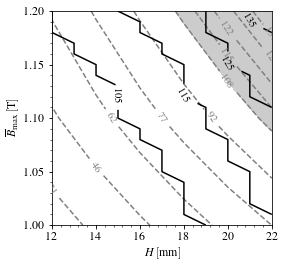

In [19]:
%matplotlib inline
fig_list_slope2D_35K = plot_Qc_and_Rs_contour()

It seems that an external radius of 120 mm can easily satisfy the target cooling capacity. We can select three operating points for three values of the magnetic field:

In [20]:
R_s_target_mm = 120
t_120 = filter_table_from_column(map_table,"R_s[mm]",R_s_target_mm)

In [21]:
B_h_values = np.array([1.1,1.15,1.20])

In [22]:
for B_h in B_h_values:
    
    t = filter_table_from_column(t_120,"B_max[T]",B_h)
    h_gap_max = np.max(t["h_gap[mm]"].values)
    H_reg_max = h_gap_max - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    print("For R_s = %d mm, B_max = %.2f T, the maximum regenerator height is %d mm" %(R_s_target_mm,B_h,H_reg_max))
    

For R_s = 120 mm, B_max = 1.10 T, the maximum regenerator height is 22 mm
For R_s = 120 mm, B_max = 1.15 T, the maximum regenerator height is 20 mm
For R_s = 120 mm, B_max = 1.20 T, the maximum regenerator height is 19 mm


For simulations of these points, comparing situations with and without the internal magnet (using an iron core instead), see the notebook `Comparison with and without the internal magnet.ipynb`.

To find the operating point for the point of $B_{\mathrm{max}} = 1.20\,\mathrm{T}$, we load the AMR simulation results and interpolate the values:

In [23]:
qc_map = pd.read_csv(QC_MAPS_FILE,sep='\t')
B_max_op_point = 1.20
qc_map_B = filter_table_from_column(qc_map,"Hmax[T]",B_max_op_point)
qc_map_B

,H[mm],Hmax[T],Test,Re_w[-],ReDp_CB[-],ReDp_HB[-],U_CB[-],U_HB[-],dPCB[kPa],dPHB[kPa],Tspan [K],dT_reg[K],Qc[W],Qh[W],Wpump[W],Wasco[W],Wmotor[W],COP[-],Q_wall-Loss[W]
2,10,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.669664,49.077647,46.291060,6.016106,20.16,6.350158,1.508862,-591.675271
5,12,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.739557,63.806365,62.602843,7.219327,20.16,8.255907,1.790541,-633.778998
8,14,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.795899,79.134803,79.595724,8.422548,20.16,10.239254,2.038411,-675.789513
11,16,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.842590,94.937258,97.125818,9.625770,20.16,12.283934,2.256666,-717.801504
14,18,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.882094,111.121220,115.092414,10.828991,20.16,14.377977,2.449386,-759.854209
17,20,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.916054,127.619766,133.416110,12.032212,20.16,16.512724,2.620264,-801.930894
20,22,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.945613,144.375459,152.038865,13.235433,20.16,18.680743,2.772390,-844.021700


In [24]:
H_reg_op_point = 19

fQc = interp1d(qc_map_B["H[mm]"].values,qc_map_B["Qc[W]"])
Qc_op_point = fQc(H_reg_op_point)

fCOP = interp1d(qc_map_B["H[mm]"].values,qc_map_B["COP[-]"])
COP_op_point = fCOP(H_reg_op_point)

T_H = FIXED_PARAMETERS_AMR["T_H[K]"]
T_C = T_H - FIXED_PARAMETERS_AMR["dT[K]"]

COP_Carnot_op_point = T_C / (T_H - T_C)

eta_2nd = COP_op_point / COP_Carnot_op_point

print("Operating point for the magnet:")
print("B_max = %.2f T" %(B_max_op_point))
print("H_reg = %d mm" %(H_reg_op_point))
print("***")
print("Performance:")
print("Q_c = %.1f W" %(Qc_op_point))
print("COP = %.1f" %(COP_op_point))
print("Second-law efficienct: %.1f %%" % (1e2*eta_2nd))



Operating point for the magnet:
B_max = 1.20 T
H_reg = 19 mm
***
Performance:
Q_c = 119.4 W
COP = 2.5
Second-law efficienct: 32.8 %
